In [1]:
import torch

import triton
import triton.language as tl

DEVICE = "cuda:0"

@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert str(x.device) == DEVICE and str(y.device) == DEVICE and str(output.device) == DEVICE
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


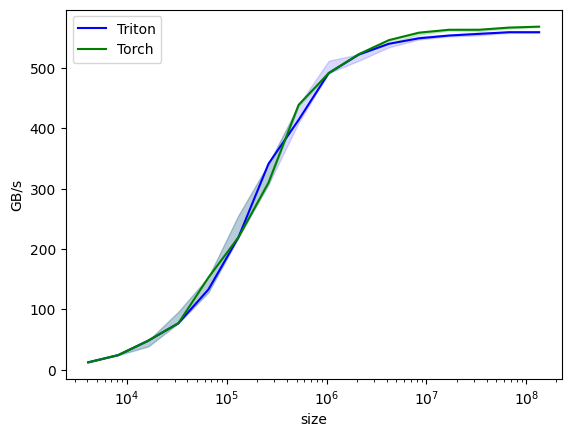

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   76.800002
4       65536.0  132.843245  152.645959
5      131072.0  219.428568  219.428568
6      262144.0  341.333321  310.107257
7      524288.0  413.911572  438.857137
8     1048576.0  491.520012  491.520012
9     2097152.0  522.199223  522.893602
10    4194304.0  540.131858  546.133325
11    8388608.0  549.184373  558.545450
12   16777216.0  553.825358  563.346690
13   33554432.0  556.556694  563.346690
14   67108864.0  559.339973  567.002176
15  134217728.0  559.339973  568.539263


In [2]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(print_data=True, show_plots=True)

In [3]:
import torch

import triton
import triton.language as tl

DEVICE = "cuda:0"


def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"


def is_hip_mi200():
    target = triton.runtime.driver.active.get_current_target()
    return target.backend == 'hip' and target.arch == 'gfx90a'


def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]


def get_hip_autotune_config():
    return [
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=4, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 4, 'waves_per_eu': 2},
            num_warps=8, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=8, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8, 'waves_per_eu': 3},
            num_warps=4, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 8},
            num_warps=4, num_stages=2),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        return get_hip_autotune_config()


# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation  #
    )
    return c

torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")
# Bigger tolerance for AMD MI200 devices.
# MI200 devices use reduced precision fp16 and bf16 and flush input and
# output denormal values to zero. Detailed info is at: https://pytorch.org/docs/stable/notes/numerical_accuracy.html#reduced-precision-fp16-and-bf16-gemms-and-convolutions-on-amd-instinct-mi200-devices
rtol = 1e-2 if is_hip_mi200() else 0
if torch.allclose(triton_output, torch_output, atol=1e-2, rtol=rtol):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8 and is_cuda():
    torch.manual_seed(0)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    # pre-transpose b for efficiency.
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_output = matmul(a, b)
    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))
    print(f"triton_output_with_fp8_inputs={triton_output}")
    print(f"torch_output_with_fp8_inputs={torch_output}")
    if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
        print("✅ Triton and Torch match")
    else:
        print("❌ Triton and Torch differ")


triton_output_with_fp16_inputs=tensor([[ -4.4844, -18.9844,   8.2500,  ..., -16.2344,  36.6562, -14.1406],
        [ 27.0781, -38.7188, -24.4531,  ..., -21.7031, -26.5938,  17.4688],
        [-13.3438,  14.1719,   7.6016,  ...,  -9.1172, -43.2500,   9.6406],
        ...,
        [  9.6406,   1.0146,  -9.3047,  ...,  -7.7852,  39.8438,  13.6172],
        [-28.8594,   8.2500,  16.6719,  ..., -33.7500, -33.3125,  56.2188],
        [ -3.8203,   0.7295,  18.9219,  ..., -33.4375,  -4.7852,  45.1562]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ -4.4844, -18.9844,   8.2500,  ..., -16.2344,  36.6562, -14.1406],
        [ 27.0781, -38.7188, -24.4531,  ..., -21.7031, -26.5938,  17.4688],
        [-13.3438,  14.1719,   7.6016,  ...,  -9.1172, -43.2500,   9.6406],
        ...,
        [  9.6406,   1.0146,  -9.3047,  ...,  -7.7852,  39.8438,  13.6172],
        [-28.8594,   8.2500,  16.6719,  ..., -33.7500, -33.3125,  56.2188],
        [ -3.8203,   0.7295,  1

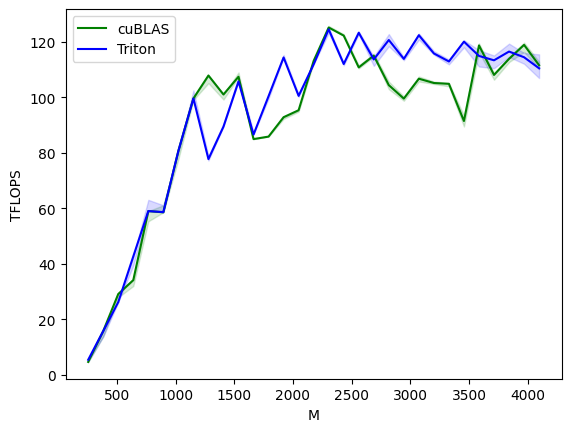

matmul-performance-fp16:
         M       N       K      cuBLAS      Triton
0    256.0   256.0   256.0    4.681143    5.461333
1    384.0   384.0   384.0   15.798857   15.798857
2    512.0   512.0   512.0   29.127110   26.214401
3    640.0   640.0   640.0   34.133334   42.666665
4    768.0   768.0   768.0   58.982401   58.982401
5    896.0   896.0   896.0   58.538665   58.614987
6   1024.0  1024.0  1024.0   80.659693   80.659693
7   1152.0  1152.0  1152.0   99.532803   99.532803
8   1280.0  1280.0  1280.0  107.789478   77.695315
9   1408.0  1408.0  1408.0  100.958815   89.373379
10  1536.0  1536.0  1536.0  107.342377  105.640118
11  1664.0  1664.0  1664.0   84.895397   86.528001
12  1792.0  1792.0  1792.0   85.797134  100.351999
13  1920.0  1920.0  1920.0   92.778524  114.277450
14  2048.0  2048.0  2048.0   95.291259  100.462368
15  2176.0  2176.0  2176.0  113.054201  111.798043
16  2304.0  2304.0  2304.0  125.067393  124.415996
17  2432.0  2432.0  2432.0  122.149841  111.930140
18  25

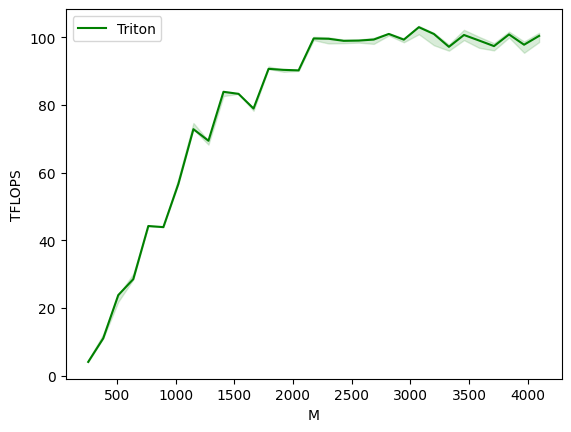

matmul-performance-fp8:
         M       N       K      Triton
0    256.0   256.0   256.0    4.096000
1    384.0   384.0   384.0   11.059200
2    512.0   512.0   512.0   23.831273
3    640.0   640.0   640.0   28.543554
4    768.0   768.0   768.0   44.236801
5    896.0   896.0   896.0   43.904000
6   1024.0  1024.0  1024.0   56.679781
7   1152.0  1152.0  1152.0   72.828879
8   1280.0  1280.0  1280.0   69.423727
9   1408.0  1408.0  1408.0   83.873477
10  1536.0  1536.0  1536.0   83.269271
11  1664.0  1664.0  1664.0   78.937823
12  1792.0  1792.0  1792.0   90.640517
13  1920.0  1920.0  1920.0   90.352941
14  2048.0  2048.0  2048.0   90.200084
15  2176.0  2176.0  2176.0   99.622022
16  2304.0  2304.0  2304.0   99.532803
17  2432.0  2432.0  2432.0   98.924166
18  2560.0  2560.0  2560.0   98.996982
19  2688.0  2688.0  2688.0   99.301194
20  2816.0  2816.0  2816.0  100.958815
21  2944.0  2944.0  2944.0   99.274968
22  3072.0  3072.0  3072.0  102.951099
23  3200.0  3200.0  3200.0  100.946373
2

In [4]:
ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'

configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8 or not is_cuda()):
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton"],  # Label name for the lines
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        b = b.T
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)

In [1]:
import torch
import triton
import triton.language as tl

# demo - syntacsis

In [7]:
@triton.jit
def demo(x_ptr, block_size: tl.constexpr):
    block_id = tl.program_id(axis=0)
    range = block_id * block_size + tl.arange(0, block_size)
    mask = range < block_size
    x = tl.load(x_ptr + range, mask, 0)
    y = tl.load(x_ptr + range, mask, 0)
    res = x + y
    tl.store(x_ptr + range, res, mask)

input_arr = torch.ones(10, dtype=torch.float32).cuda()

block_size = 8

print("Input: ", input_arr)

demo[(2,)](input_arr, block_size=block_size)

print("Output: ", input_arr)


Input:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Output:  tensor([2., 2., 2., 2., 2., 2., 2., 2., 1., 1.], device='cuda:0')


# Puzzles

In [1]:
import torch
import triton
import triton.language as tl

from torch import Tensor
import jaxtyping
from jaxtyping import Float32, Int32

import triton_viz
import inspect
from triton_viz.interpreter import record_builder

In [7]:
@triton.jit
def add_kernel(
    x_ptr, 
    y_ptr,  
    output_ptr,  
    n_elements,  
    BLOCK_SIZE: tl.constexpr, 
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    print(mask)
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    print(x)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)

x = torch.tensor([1, 2, 3, 4, 4, 3, 2, 1, 0, 1], dtype=torch.float32, device='cuda')
y = torch.tensor([10, 20, 30, 40, 40, 30, 20, 10, 0, 10], dtype=torch.float32, device='cuda')

print(x)
print(y)
output = torch.empty_like(x)
n_elements = x.numel()  
grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

triton_viz.trace(add_kernel)[grid](x_ptr=x, y_ptr=y, output_ptr=output, n_elements=n_elements, BLOCK_SIZE=4)
print()
print(output)  


triton_viz.launch()

tensor([1., 2., 3., 4., 4., 3., 2., 1., 0., 1.], device='cuda:0')
tensor([10., 20., 30., 40., 40., 30., 20., 10.,  0., 10.], device='cuda:0')
[ True  True  True  True]
[1. 2. 3. 4.]
[ True  True  True  True]
[4. 3. 2. 1.]
[ True  True False False]
[0. 1. 0. 0.]

tensor([11., 22., 33., 44., 44., 33., 22., 11.,  0., 11.], device='cuda:0')
* Running on public URL: https://82029bafd28ccea87b.gradio.live


{}

# Atomic Operations

In [5]:
import torch
import triton
import triton.language as tl

@triton.jit
def demo(x_ptr):
    range = tl.arange(0, 8)
    mask = range < 5
    x = tl.load(x_ptr + range, mask, 0)
    y = tl.load(x_ptr + range, mask, 0)
    res = x + y
    tl.store(x_ptr + range, res, mask)

input_arr = torch.ones(8, dtype=torch.float32).cuda()

print("Input: ", input_arr)

demo[(10,)](input_arr)

print("Output: ", input_arr)

Input:  tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Output:  tensor([2., 2., 2., 2., 2., 1., 1., 1.], device='cuda:0')


Atomic Operations in Triton

---

- `atomic_add`
Performs an atomic add at the memory location specified by `pointer`.

---

- `atomic_and`
Performs an atomic logical AND at the memory location specified by `pointer`.

---

- `atomic_cas`
Performs an atomic compare-and-swap at the memory location specified by `pointer`.

---

- `atomic_max`
Performs an atomic max at the memory location specified by `pointer`.

---

- `atomic_min`
Performs an atomic min at the memory location specified by `pointer`.

---

- `atomic_or`
Performs an atomic logical OR at the memory location specified by `pointer`.

---

- `atomic_xchg`
Performs an atomic exchange at the memory location specified by `pointer`.

---

- `atomic_xor`
Performs an atomic logical XOR at the memory location specified by `pointer`.

---


In [6]:
import torch
import triton
import triton.language as tl

@triton.jit
def atomic_demo(x_ptr):
    range = tl.arange(0, 8)
    mask = range < 5
    x = tl.load(x_ptr + range, mask, 0)
    tl.atomic_add(x_ptr + range, x + 1, mask)  

input_arr = torch.ones(8, dtype=torch.float32).cuda()

print("Input: ", input_arr)

atomic_demo[(2,)](input_arr)

print("Output:", input_arr)


Input:  tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Output: tensor([5., 5., 5., 5., 5., 1., 1., 1.], device='cuda:0')


---

Input 

**x_ptr = [1., 1., 1., 1., 1., 1., 1., 1.]**

---

### Step 1: Pid = 0
- `x = tl.load(x_ptr + range, mask, 0)`  # [1., 1., 1., 1., 1., 1., 1., 1.]
- `x = x + 1`                           # [2., 2., 2., 2., 2., 1., 1., 1.]
- `tl.atomic_add(x_ptr + range, x + 1, mask)`  


**x_ptr = [3., 3., 3., 3., 3., 1., 1., 1.]**

---

### Step 2: Pid = 1
- `x = tl.load(x_ptr + range, mask, 0)`  # [1., 1., 1., 1., 1., 1., 1., 1.]
- `res = x + 1`                          # [2., 2., 2., 2., 2., 1., 1., 1.]
- `tl.atomic_add(x_ptr + range, x + 1, mask)`  


**x_ptr = [5., 5., 5., 5., 5., 1., 1., 1.]**

---






# Runtime error: invalid memory address / Segmentation Fault (segfault)

In [1]:
import torch
import triton
import triton.language as tl
from torch import Tensor
import jaxtyping
from jaxtyping import Float32, Int32

import triton_viz
import inspect
from triton_viz.interpreter import record_builder


In [2]:
@triton.jit
def demo(x_ptr):
    range = tl.arange(0, 8)
    print("Range: ", range)
    mask = range < 5
    x = tl.load(x_ptr + range, mask, 0)
    y = tl.load(x_ptr + range, mask, 0)
    res = x + y
    print(res)
    tl.store(x_ptr + range, res, mask)

input_arr = torch.ones(3, dtype=torch.float32).cuda()

print("Input: ", input_arr)

triton_viz.trace(demo)[(1,)](input_arr)

print("Output: ", input_arr)

triton_viz.launch()

Input:  tensor([1., 1., 1.], device='cuda:0')
Range:  [0 1 2 3 4 5 6 7]
[ 2.00000000e+00  2.00000000e+00  2.00000000e+00  0.00000000e+00
 -1.05280536e+21  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Output:  tensor([2., 2., 2.], device='cuda:0')
* Running on public URL: https://4696970fd097007248.gradio.live


{(0, 0, 0): True}

# Type Promotion

In [1]:
import triton
import triton.language as tl
import torch

@triton.jit
def type_promotion_example(x_ptr, y_ptr, res_ptr):
    range = tl.arange(0, 8)
    
    # Load inputs
    x = tl.load(x_ptr + range)
    y = tl.load(y_ptr + range)
    
    # Type Promotion examples:
    # Case 1: Different kinds (int32 and float16)
    result1 = x + y  # Promotes int32 to float16
    
    # Case 2: Same kind but different widths (float16 and float32)
    z = tl.cast(x, tl.float16)  # Explicitly casting x to float16
    result2 = z + y  # Promotes float16 to float32
    
    # Store results
    tl.store(res_ptr + range, result1)
    tl.store(res_ptr + range + 8, result2)

# Prepare data
x_tensor = torch.arange(8, dtype=torch.int32).cuda()       # int32 tensor
y_tensor = (torch.arange(8, dtype=torch.float16) * 0.1).cuda()  # float16 tensor
res_tensor = torch.empty(16, dtype=torch.float32).cuda()  # float32 output tensor for results

# Run kernel
type_promotion_example[(1,)](x_tensor, y_tensor, res_tensor)

# Display results
print("Input x:", x_tensor)
print("Input y:", y_tensor)
print("Result 1 (int32 + float16):", res_tensor[:8])  # Promoted to float16
print("Result 2 (float16 + float32):", res_tensor[8:])  # Promoted to float32


Input x: tensor([0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0', dtype=torch.int32)
Input y: tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.3999, 0.5000, 0.6001, 0.7002],
       device='cuda:0', dtype=torch.float16)
Result 1 (int32 + float16): tensor([0.0000, 1.0996, 2.1992, 3.3008, 4.3984, 5.5000, 6.6016, 7.6992],
       device='cuda:0')
Result 2 (float16 + float32): tensor([0.0000, 1.0996, 2.1992, 3.3008, 4.3984, 5.5000, 6.6016, 7.6992],
       device='cuda:0')


# Broadcasting

In [2]:
import triton
import triton.language as tl
import torch

@triton.jit
def broadcast_example(x_ptr, y_ptr, res_ptr):
    range = tl.arange(0, 8) 

    x = tl.load(x_ptr + range)  # (8,)
    y = tl.load(y_ptr) # float32     

    # Broadcasting: float32 -> (8,) float32
    result = x + y

    tl.store(res_ptr + range, result)

x_tensor = torch.arange(8, dtype=torch.float32).cuda()  # [0, 1, 2, ..., 7]
y_tensor = torch.tensor([10], dtype=torch.float32).cuda()  # [10]
res_tensor = torch.empty(8, dtype=torch.float32).cuda()

broadcast_example[(1,)](x_tensor, y_tensor, res_tensor)

print("Input x:", x_tensor)
print("Input x shape:", x_tensor.shape)
print()
print("Input y:", y_tensor)
print("Input y shape:", y_tensor.shape)
print()
print("Result (x + y):", res_tensor)
print("Result (x + y) shape:", res_tensor.shape)


Input x: tensor([0., 1., 2., 3., 4., 5., 6., 7.], device='cuda:0')
Input x shape: torch.Size([8])

Input y: tensor([10.], device='cuda:0')
Input y shape: torch.Size([1])

Result (x + y): tensor([10., 11., 12., 13., 14., 15., 16., 17.], device='cuda:0')
Result (x + y) shape: torch.Size([8])


In [1]:
import triton
import triton.language as tl
import torch

@triton.jit
def multi_dim_broadcast_example(x_ptr, y_ptr, res_ptr, n: tl.constexpr, m: tl.constexpr):
    row = tl.arange(0, m)  
    col = tl.arange(0, n)  

    x = tl.load(x_ptr + col)  # (1, 8)
    y = tl.load(y_ptr + row)[:, None]  # (4, 1)

    # Broadcasting: x -> (4, 8), y -> (4, 8)
    result = x + y

    tl.store(res_ptr + row[:, None] * n + col[None, :], result)


m, n = 4, 8

x_tensor = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=torch.float32).cuda()  # (1, 8)
y_tensor = torch.tensor([[10], [20], [30], [40]], dtype=torch.float32).cuda()  # (4, 1)
res_tensor = torch.empty((4, 8), dtype=torch.float32).cuda()  # (4, 8)

multi_dim_broadcast_example[(1,)](
    x_tensor, y_tensor, res_tensor, n, m
)

print("Input x:", x_tensor)
print("Input x shape:", x_tensor.shape)
print()
print("Input y:", y_tensor)
print("Input y shape:", y_tensor.shape)
print()
print("Result (x + y):", res_tensor)
print("Result (x + y) shape:", res_tensor.shape)

Input x: tensor([[1., 2., 3., 4., 5., 6., 7., 8.]], device='cuda:0')
Input x shape: torch.Size([1, 8])

Input y: tensor([[10.],
        [20.],
        [30.],
        [40.]], device='cuda:0')
Input y shape: torch.Size([4, 1])

Result (x + y): tensor([[11., 12., 13., 14., 15., 16., 17., 18.],
        [21., 22., 23., 24., 25., 26., 27., 28.],
        [31., 32., 33., 34., 35., 36., 37., 38.],
        [41., 42., 43., 44., 45., 46., 47., 48.]], device='cuda:0')
Result (x + y) shape: torch.Size([4, 8])


# Rounding

In [4]:
@triton.jit
def rounding_example(x_ptr, res_ptr):
    range = tl.arange(0, 8)

    x = tl.load(x_ptr + range)

    result = x // 3  

    tl.store(res_ptr + range, result)

x_tensor = torch.tensor([-7, -4, -1, 0, 1, 4, 7, 10], dtype=torch.int32).cuda()
res_tensor = torch.empty(8, dtype=torch.int32).cuda()

rounding_example[(1,)](x_tensor, res_tensor)

print("Input x:", x_tensor)
print()
print("Python Result (x // 3):", x_tensor//3)
print()
print("Triton Result (x // 3):", res_tensor)


Input x: tensor([-7, -4, -1,  0,  1,  4,  7, 10], device='cuda:0', dtype=torch.int32)

Python Result (x // 3): tensor([-3, -2, -1,  0,  0,  1,  2,  3], device='cuda:0', dtype=torch.int32)

Triton Result (x // 3): tensor([-2, -1,  0,  0,  0,  1,  2,  3], device='cuda:0', dtype=torch.int32)


# Print 

In [3]:
import triton
import triton.language as tl
import torch

@triton.jit
def kernel_static_print_example(x_ptr, BLOCK_SIZE: tl.constexpr):
    tl.static_print(f"BLOCK_SIZE={BLOCK_SIZE}")
    idx = tl.arange(0, BLOCK_SIZE)
    x = idx * 2
    tl.static_print("x", x)
    tl.store(x_ptr + idx, x)

BLOCK_SIZE = 8
x_tensor = torch.empty(BLOCK_SIZE, dtype=torch.int32).cuda()

kernel_static_print_example[(1,)](x_tensor, BLOCK_SIZE=BLOCK_SIZE)

print("Output tensor:", x_tensor)

BLOCK_SIZE=8
x int32[constexpr[8]]
Output tensor: tensor([ 0,  2,  4,  6,  8, 10, 12, 14], device='cuda:0', dtype=torch.int32)


In [ ]:
import triton
import triton.language as tl
import torch

@triton.jit
def kernel_device_print_example(x_ptr, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)
    x = tl.load(x_ptr + idx)
    tl.device_print("Index", idx)
    tl.device_print("Value", x)

BLOCK_SIZE = 8
x_tensor = torch.arange(0, BLOCK_SIZE, dtype=torch.int32).cuda()

kernel_device_print_example[(1,)](x_tensor, BLOCK_SIZE=BLOCK_SIZE)


pid (0, 0, 0) idx (0) Index: 0
pid (0, 0, 0) idx (1) Index: 1
pid (0, 0, 0) idx (2) Index: 2
pid (0, 0, 0) idx (3) Index: 3
pid (0, 0, 0) idx (4) Index: 4
pid (0, 0, 0) idx (5) Index: 5
pid (0, 0, 0) idx (6) Index: 6
pid (0, 0, 0) idx (7) Index: 7
pid (0, 0, 0) idx (0) Index: 0
pid (0, 0, 0) idx (1) Index: 1
pid (0, 0, 0) idx (2) Index: 2
pid (0, 0, 0) idx (3) Index: 3
pid (0, 0, 0) idx (4) Index: 4
pid (0, 0, 0) idx (5) Index: 5
pid (0, 0, 0) idx (6) Index: 6
pid (0, 0, 0) idx (7) Index: 7
pid (0, 0, 0) idx (0) Index: 0
pid (0, 0, 0) idx (1) Index: 1
pid (0, 0, 0) idx (2) Index: 2
pid (0, 0, 0) idx (3) Index: 3
pid (0, 0, 0) idx (4) Index: 4
pid (0, 0, 0) idx (5) Index: 5
pid (0, 0, 0) idx (6) Index: 6
pid (0, 0, 0) idx (7) Index: 7
pid (0, 0, 0) idx (0) Index: 0
pid (0, 0, 0) idx (1) Index: 1
pid (0, 0, 0) idx (2) Index: 2
pid (0, 0, 0) idx (3) Index: 3
pid (0, 0, 0) idx (4) Index: 4
pid (0, 0, 0) idx (5) Index: 5
pid (0, 0, 0) idx (6) Index: 6
pid (0, 0, 0) idx (7) Index: 7
pid (0, 

# Pointer Arithmetic 

**Way to swap elements without explisit swap using ponter arithmetic**

---

[10, 11, 12, 13, 14, 15] -> [ 11, 10, 13, 12, 15, 14]

---

range = [0, 1, 2, 3, 4, 5]

Necessary_range = [1, 0, 3, 2, 5, 4]

---

[0, 1, 2, 3, 4, 5]

[1, 0, 3, 2, 5, 4]

**[1, -1, 1, -1, 1, -1]**

---
**value % 2**

Odd_range:  [1, 0, 1, 0, 1, 0]

Even_range:  [0, 1, 0, 1, 0, 1]

**Odd_range - Even_range = [1, -1, 1, -1, 1, -1]**

---

Range_swaped:  [1, 0, 3, 2, 5, 4]

In [1]:
import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import Float32, Int32

import triton_viz
import inspect
from triton_viz.interpreter import record_builder

@triton.jit
def swap_every_second_element(x_ptr, res_ptr, N0, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(0)
    range = tl.arange(0, BLOCK_SIZE) + pid*BLOCK_SIZE
    mask = range < N0
    
    print("\nRange: ", range)
    range_even = range % 2 
    
    range_odd = (range+1) % 2

    print("Odd: ", range_odd)
    print("Even: ", range_even)

    necessary_range = range_odd - range_even

    print("Necessary_range: ", necessary_range)

    range_swaped = range + necessary_range

    print("Range_swaped: ", range_swaped)
    

    x = tl.load(x_ptr + range_swaped, mask)

    tl.store(res_ptr + range, x, mask)

x_tensor = torch.tensor([10, 11, 12, 13, 14, 15], dtype=torch.int32).cuda()
n_elements = x_tensor.numel()
BLOCK_SIZE = 4
res_tensor = torch.zeros_like(x_tensor).cuda()

grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

triton_viz.trace(swap_every_second_element)[grid](x_tensor, res_tensor, n_elements, BLOCK_SIZE)


print("\nInput:", x_tensor)
print("Output:", res_tensor)

triton_viz.launch()



Range:  [0 1 2 3]
Odd:  [1 0 1 0]
Even:  [0 1 0 1]
Necessary_range:  [ 1 -1  1 -1]
Range_swaped:  [1 0 3 2]

Range:  [4 5 6 7]
Odd:  [1 0 1 0]
Even:  [0 1 0 1]
Necessary_range:  [ 1 -1  1 -1]
Range_swaped:  [5 4 7 6]

Input: tensor([10, 11, 12, 13, 14, 15], device='cuda:0', dtype=torch.int32)
Output: tensor([11, 10, 13, 12, 15, 14], device='cuda:0', dtype=torch.int32)
* Running on public URL: https://0ef8c7b75659266f40.gradio.live


{}

In [4]:
def test(puzzle, puzzle_spec, nelem={}, B={"B0": 32}, viz=True):
    B = dict(B)
    if "N1" in nelem and "B1" not in B:
        B["B1"] = 32
    if "N2" in nelem and "B2" not in B:
        B["B2"] = 32

    triton_viz.interpreter.record_builder.reset()
    torch.manual_seed(0)
    signature = inspect.signature(puzzle_spec)
    args = {}
    for n, p in signature.parameters.items():
        print(p)
        args[n + "_ptr"] = ([d.size for d in p.annotation.dims], p)
    args["z_ptr"] = ([d.size for d in signature.return_annotation.dims], None)

    tt_args = []
    for k, (v, t) in args.items():
        tt_args.append(torch.rand(*v) - 0.5)
        if t is not None and t.annotation.dtypes[0] == "int32":
            tt_args[-1] = torch.randint(-100000, 100000, v)
    grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)),
                         triton.cdiv(nelem.get("N2", 1), meta.get("B2", 1)))

    #for k, v in args.items():
    #    print(k, v)
    triton_viz.trace(puzzle)[grid](*tt_args, **B, **nelem)
    z = tt_args[-1]
    tt_args = tt_args[:-1]
    z_ = puzzle_spec(*tt_args)
    match = torch.allclose(z, z_, rtol=1e-3, atol=1e-3)
    print("Results match:",  match)
    print("Yours:", z)
    print("Spec:", z_)
    print(torch.isclose(z, z_))
    print("Correct!")

    triton_viz.launch()


def dot_spec(x: Float32[Tensor, "1 64 32"], y: Float32[Tensor, "1 32 32"]) -> Float32[Tensor, "1 64 32"]:
    return x @ y

@triton.jit
def dot_kernel(x_ptr, y_ptr, z_ptr, N0, N1, N2, MID, B0: tl.constexpr, B1: tl.constexpr, B2: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    pid_2 = tl.program_id(2)

    # Define offsets and load for out
    outs = tl.full((B2, B0, B1), 0.0, dtype=tl.float32)

    pid_0_off = (tl.arange(0, B0) + pid_0 * B0) * N1
    pid_1_off = tl.arange(0, B1) + pid_1 * B1
    pid_2_off = (tl.arange(0, B2) + pid_2 * B2) * N0 * N1
    off = pid_2_off[:, None, None] + pid_0_off[None, :, None] + pid_1_off[None, None, :]

    # can make this cleaner lowkey
    out_mask = ((tl.arange(0, B0) + pid_0 * B0) < N0)[None, :, None] + \
               ((tl.arange(0, B1) + pid_1 * B1) < N1)[None, None, :] + \
               ((tl.arange(0, B2) + pid_2 * B2) < N2)[:, None, None]
    # the strategy is to tile based on output chunks
    for k in range(0, MID, B_MID):
      off_x_d0 = (tl.arange(0, B0) + pid_0 * B0) * MID
      off_x_d1 = (tl.arange(0, B_MID) + k)
      off_x = pid_2_off[:, None, None] + off_x_d0[None, :, None] + off_x_d1[None, None, :]
      mask_x = (off_x_d1 < MID)[None, None, :] & ((tl.arange(0, B0) + pid_0 * B0) < N0)[None, :, None]

      off_y_d0 = tl.arange(0, B1) + pid_1 * B1
      off_y_d1 = (tl.arange(0, B_MID) + k) * N1
      off_y = pid_2_off[:, None, None] + off_y_d1[None, :, None] + off_y_d0[None, None, :]
      mask_y = ((tl.arange(0, B_MID) + k) < MID)[None, :, None] & (off_y_d0 < N1)[None, None, :]
      # load in data
      x = tl.load(x_ptr + off_x, mask_x, 0)
      y = tl.load(y_ptr + off_y, mask_y, 0)
      outs += tl.dot(x, y)

    tl.store(z_ptr + off, outs, out_mask)


test(dot_kernel, dot_spec, B={"B0": 16, "B1": 16, "B2": 1, "B_MID": 16}, nelem={"N0": 64, "N1": 32, "N2": 1, "MID": 32})

x: jaxtyping.Float32[Tensor, '1 64 32']
y: jaxtyping.Float32[Tensor, '1 32 32']


Results match: True
Yours: tensor([[[-0.8584,  0.0920, -0.6860,  ...,  0.0199,  0.5499,  0.2774],
         [-0.2950, -0.3414,  0.2293,  ..., -0.8356,  0.0666,  0.5269],
         [-0.1228, -0.1753, -0.3745,  ..., -0.2319, -0.0221,  0.0163],
         ...,
         [ 0.1015, -0.1543, -0.2599,  ..., -0.7748, -0.3515,  0.2456],
         [ 0.1894, -0.6542,  0.5398,  ...,  0.1292,  0.2913, -0.3808],
         [ 0.5655, -0.4706,  0.2540,  ..., -0.1389, -0.2770, -0.5499]]])
Spec: tensor([[[-0.8584,  0.0920, -0.6860,  ...,  0.0199,  0.5499,  0.2774],
         [-0.2950, -0.3414,  0.2293,  ..., -0.8356,  0.0666,  0.5269],
         [-0.1228, -0.1753, -0.3745,  ..., -0.2319, -0.0221,  0.0163],
         ...,
         [ 0.1015, -0.1543, -0.2599,  ..., -0.7748, -0.3515,  0.2456],
         [ 0.1894, -0.6542,  0.5398,  ...,  0.1292,  0.2913, -0.3808],
         [ 0.5655, -0.4706,  0.2540,  ..., -0.1389, -0.2770, -0.5499]]])
tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  .